# Atividade 7 - Classificador SVM

# Branch and Bound -  Normalizado

# Algoritmo SVC

SVM:

● Realizar validação cruzada k=10 para testar SVMs utilizando:
    - todas a características
    - apenas com os componentes principais
    - apenas com as características selecionadas pelo selecionador 1
    - apenas com as características selecionadas pelo selecionador 2 (opcional)

Em cada um, calibrar os parâmetros (kernel, parâmetros do kernel e C) e reportar os valores médios de precisão, revocação e acurácia para o que apresentou melhor acurácia (com os respectivos intervalos de confiança)

## Dataset Completo

In [1]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pandas import read_csv
from sklearn.model_selection import StratifiedKFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

#normalizacao
from sklearn import preprocessing


# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Classificador
from sklearn.svm import SVC # C-Support Vector Classification
from sklearn.svm import LinearSVC # Linear Support Vector Classification
from sklearn.svm import NuSVC # Nu-Support Vector Classification


# Balanceamento das classes
from imblearn.combine import SMOTETomek

# Validação
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from scipy import stats as st

# pipeline
from sklearn.pipeline import Pipeline

import warnings

warnings.filterwarnings("ignore")

random_state=5007

%matplotlib inline

In [2]:
# importa dataset

df = read_csv('../../data/kag_risk_factors_cervical_cancer.csv')

print(df.shape)

#df.head()

(858, 36)


### Características selecionadas pelo Branch and Bound na atividade 4

In [3]:
selecionadas_BB = ['Age','Number of sexual partners',
                   'First sexual intercourse', 'Num of pregnancies',
                   'Hormonal Contraceptives (years)','Hinselmann']


## Pré-Processamento

In [4]:
# substituindo ? por NAN
df.replace('?', np.NAN,inplace=True)

In [5]:
# Transforma as feature em numericas
df_processed = df.apply(pd.to_numeric, errors="ignore")

# Resultado final com as devidas alteracoes
#df_processed.info() 

## Eliminação (ou não) de instâncias com missing values

Para features continuas --> preenche com a mediana (para nao ter muito impacto com outliers)

Hipotese:
 - Para features categoricas --> preenche com o valor mais frequente
 
No decorrer dos experimentos validar se a hipotese é aceita ou não.

(Uma alternativa seria imputar os valores pelo moda (valor mais frequente), que provavelmente é uma solução ruim, pois a resposta verdadeira pode estar correlacionada com a probabilidade de um valor estar ausente. Pois isso teremos um bias, pois esses valores são privados e a pessoa pode escolher não divulga-los)

In [6]:
continuous_feat = ['Age',
                   'Number of sexual partners',
                   'First sexual intercourse',
                   'Num of pregnancies', 
                   'Smokes (years)',
                   'Smokes (packs/year)',
                   'Hormonal Contraceptives (years)',
                   'IUD (years)',
                   'STDs (number)',
                   'STDs: Number of diagnosis',
                   'STDs: Time since first diagnosis',
                   'STDs: Time since last diagnosis'] 

binary_feat = [  'Smokes',
                 'Hormonal Contraceptives',
                 'IUD',
                 'STDs',
                 'STDs:condylomatosis',
                 'STDs:cervical condylomatosis',
                 'STDs:vaginal condylomatosis',
                 'STDs:vulvo-perineal condylomatosis',
                 'STDs:syphilis',
                 'STDs:pelvic inflammatory disease',
                 'STDs:genital herpes',
                 'STDs:molluscum contagiosum',
                 'STDs:AIDS',
                 'STDs:HIV',
                 'STDs:Hepatitis B',
                 'STDs:HPV',
                 'Dx:Cancer',
                 'Dx:CIN',
                 'Dx:HPV',
                 'Dx',
                 'Hinselmann',
                 'Schiller',
                 'Citology']                               


In [7]:
df_imp = df_processed.copy()

In [8]:
# preenche com a mediana
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
df_imp[continuous_feat] = imp_median.fit_transform(df_processed[continuous_feat])

# preenche com o valor mais frequente
imp_most_freq = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
df_imp[binary_feat] = imp_most_freq.fit_transform(df_processed[binary_feat])

#df_imp.isnull().sum()


## Stratified Cross- Validation

### Dataset Desbalanceado

In [9]:
# Cross Validation com dataset DESBALANCEADO

def stratified_k_fold(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    
    # quantidade original de classes
    count_classes = y.value_counts()
    
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
        
    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    kernels = grid_params.get('kernels')
    gamma_range = grid_params.get('gamma_range')
    gamma_step = grid_params.get('gamma_step')
    C_range = grid_params.get('C_range')
    
    # Testa varios KERNELS
    for kernel in kernels:
        print("-> Teste Kernel {}".format(kernel))
        
        # Testa varios C
        for c in C_range:
#             print("\t\tTeste Param C {}".format(c))
        
            if kernel in ['rbf', 'poly', 'sigmoid']:
                # Testa varios GAMMA
                for gamma in list(np.arange(gamma_range[0], gamma_range[1], gamma_step))+['scale', 'auto']:
#                     print("\t\t\tTeste Param Gamma {}".format(gamma))
                    
                    print('-> Criando modelo com params c={}, gamma={}'.format(c, gamma))
                    pipe_clf = Pipeline([('scaler', preprocessing.StandardScaler()), 
                                           ('clf', algoritmo(kernel=kernel, gamma=gamma, C=c, 
                                                             verbose=1, shrinking=shrinking))])        
                    
                    # Folds
                    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                        fold_number = fold
                        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                        # quantidade de classes dentro da fold
                        count_classes_fold = y.iloc[test_index].value_counts()
                        # proporções
                        prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                        prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                        print('Fold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                            count_classes_fold[1],
                                                                                            count_classes_fold[0], 
                                                                                            count_classes_fold.sum(),
                                                                                            prop_pos, prop_neg))

                        # aplica o classificador
                        pipe_clf.fit(X_train, y_train)
                        #display(clf)

                        # predict no dataset de treino 
                        y_train_preds = pipe_clf.predict(X_train)
                        # predict no dataset de teste
                        y_pred = pipe_clf.predict(X_test)

                        print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                         % (y_test.shape[0], (y_test != y_pred).sum()))
                       # print("Number of points predicted as Pos: %d"
                       #  % ((y_pred == 1).sum()))

                        # Scores do model (utilizados dados nao-balanceados) - dados de teste
                        recall = recall_score(y_test, y_pred)
                        accuracy = accuracy_score(y_test, y_pred)
                        precision = precision_score(y_test, y_pred)
                        scores.append([kernel, c, gamma, fold_number, precision, recall, accuracy])

            #return np.array(scores)
            else:
                print('-> Criando modelo com params c={}'.format(c))
                pipe_clf = Pipeline([('scaler', preprocessing.StandardScaler()), 
                                     ('clf', algoritmo(kernel=kernel, C=c, verbose=1, shrinking=shrinking))])
                
                # utilizando valor default de gamma
                #gamma = clf.gamma # para acompanhamento dos scores
                gamma = pipe_clf.get_params()['clf'].gamma
                
                # Folds
                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                    fold_number = fold
                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                    # quantidade de classes dentro da fold
                    count_classes_fold = y.iloc[test_index].value_counts()
                    # proporções
                    prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                    prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                    print('Fold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                        count_classes_fold[1],
                                                                                        count_classes_fold[0], 
                                                                                        count_classes_fold.sum(),
                                                                                        prop_pos, prop_neg))
                    
                    # aplica o classificador
                    pipe_clf.fit(X_train, y_train)
                    #display(clf)

                    # predict no dataset de treino 
                    y_train_preds = pipe_clf.predict(X_train)
                    # predict no dataset de teste
                    y_pred = pipe_clf.predict(X_test)
                    
                    print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                     % (y_test.shape[0], (y_test != y_pred).sum()))
                   # print("Number of points predicted as Pos: %d"
                   #  % ((y_pred == 1).sum()))

                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                    recall = recall_score(y_test, y_pred)
                    accuracy = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred)
                    scores.append([kernel, c, gamma, fold_number, precision, recall, accuracy])

    return np.array(scores)

### Dataset Balanceado

In [10]:
# Cross Validation com dataset BALANCEADO (SMOTETomek)

def stratified_k_fold_SMOTE(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    # quantidade original de classes
    count_classes = y.value_counts()
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset (desbalanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
   
    # Normalização MinMax
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    
    # SMOTETomek
    cc = SMOTETomek(random_state=random_state)

    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    kernels = grid_params.get('kernels')
    gamma_range = grid_params.get('gamma_range')
    gamma_step = grid_params.get('gamma_step')
    C_range = grid_params.get('C_range')
    
    # Testa varios KERNELS
    for kernel in kernels:
        print("-> Teste Kernel {}".format(kernel))
        
        # Testa varios C
        for c in C_range:
#             print("\t\tTeste Param C {}".format(c))
        
            if kernel in ['rbf', 'poly', 'sigmoid']:
                # Testa varios GAMMA
                for gamma in list(np.arange(gamma_range[0], gamma_range[1], gamma_step))+['scale', 'auto']:
#                     print("\t\t\tTeste Param Gamma {}".format(gamma))
                    
                    print('-> Criando modelo com params c={}, gamma={}'.format(c, gamma))
                    pipe_clf = Pipeline([('scaler', preprocessing.StandardScaler()), 
                                         ('clf', algoritmo(kernel=kernel, gamma=gamma, C=c, 
                                                           verbose=1, shrinking=shrinking))])  
                    
                    # Folds
                    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                        fold_number = fold
                        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
                        
                        # Normaliza MinMax para aplicar Smote
                        X_train_normalized = minmax_scale.fit_transform(X_train)
                        X_train_normalized = pd.DataFrame(X_train_normalized, columns = X.columns.tolist())
                        
                        # SMOTETomek (apenas os dados de treino)
                        print('\tBalanceando dados de treino fold {}...'.format(fold_number))
                        X_train, y_train = cc.fit_resample(X_train_normalized, y_train)
                        
                        # Retorna para valores não normalizados
                        X_train = pd.DataFrame(minmax_scale.inverse_transform(X_train), columns = X.columns.tolist())
                        print('\t\tFold = {}, Dataset (balanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(fold_number, 
                                                                                                 y_train.value_counts()[0], 
                                                                                                 y_train.value_counts()[1], 
                                                                                                 ((y_train.value_counts()[0]/len(y_train))*100), 
                                                                                                 ((y_train.value_counts()[1]/len(y_train))*100)))

                        # quantidade de classes dentro da fold
                        count_classes_fold = y_test.value_counts()
                        # proporções
                        prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                        prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                        print('\t\tDados de teste (desbalanceados)')
                        print('\t\tFold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                            count_classes_fold[1],
                                                                                            count_classes_fold[0], 
                                                                                            count_classes_fold.sum(),
                                                                                            prop_pos, prop_neg))
                        # aplica o classificador
                        pipe_clf.fit(X_train, y_train)
                        #display(clf)

                        # predict no dataset de treino 
                        y_train_preds = pipe_clf.predict(X_train)
                        # predict no dataset de teste
                        y_pred = pipe_clf.predict(X_test)

                        print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                         % (y_test.shape[0], (y_test != y_pred).sum()))
                       # print("Number of points predicted as Pos: %d"
                       #  % ((y_pred == 1).sum()))

                        # Scores do model (utilizados dados nao-balanceados) - dados de teste
                        recall = recall_score(y_test, y_pred)
                        accuracy = accuracy_score(y_test, y_pred)
                        precision = precision_score(y_test, y_pred)
                        scores.append([kernel, c, gamma, fold_number, precision, recall, accuracy])

            #return np.array(scores)
            else:
                print('-> Criando modelo com params c={}'.format(c))
                pipe_clf = Pipeline([('scaler', preprocessing.StandardScaler()),
                                     ('clf', algoritmo(kernel=kernel, C=c, verbose=1, shrinking=shrinking))])
                
                # utilizando valor default de gamma
                #gamma = clf.gamma # para acompanhamento dos scores
                gamma = pipe_clf.get_params()['clf'].gamma
                
                # Folds
                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                    fold_number = fold
                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                    # Normaliza MinMax para aplicar Smote
                    X_train_normalized = minmax_scale.fit_transform(X_train)
                    X_train_normalized = pd.DataFrame(X_train_normalized, columns = X.columns.tolist())

                    # SMOTETomek (apenas os dados de treino)
                    print('\tBalanceando dados de treino fold {}...'.format(fold_number))
                    X_train, y_train = cc.fit_resample(X_train_normalized, y_train)

                    # Retorna para valores não normalizados
                    X_train = pd.DataFrame(minmax_scale.inverse_transform(X_train), columns = X.columns.tolist())
                    print('\t\tFold = {}, Dataset (balanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(fold_number, 
                                                                                             y_train.value_counts()[0], 
                                                                                             y_train.value_counts()[1], 
                                                                                             ((y_train.value_counts()[0]/len(y_train))*100), 
                                                                                             ((y_train.value_counts()[1]/len(y_train))*100)))

                    # quantidade de classes dentro da fold
                    count_classes_fold = y_test.value_counts()
                    # proporções
                    prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                    prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                    print('\t\tDados de teste (desbalanceados)')
                    print('\t\tFold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                        count_classes_fold[1],
                                                                                        count_classes_fold[0], 
                                                                                        count_classes_fold.sum(),
                                                                                        prop_pos, prop_neg))
                    # aplica o classificador
                    pipe_clf.fit(X_train, y_train)
                    #display(clf)

                    # predict no dataset de treino 
                    y_train_preds = pipe_clf.predict(X_train)
                    # predict no dataset de teste
                    y_pred = pipe_clf.predict(X_test)

                    print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                     % (y_test.shape[0], (y_test != y_pred).sum()))
                   # print("Number of points predicted as Pos: %d"
                   #  % ((y_pred == 1).sum()))

                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                    recall = recall_score(y_test, y_pred)
                    accuracy = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred)
                    scores.append([kernel, c, gamma, fold_number, precision, recall, accuracy])

    return np.array(scores)

## Grid de Parametros para teste

In [11]:
grid_params_all = {'gamma_range': [1e-4, 10e-1],
               'gamma_step': 0.01,
               'kernels': ['linear', 'poly', 'rbf', 'sigmoid'],#, 'precomputed'],
               'C_range': [1, 10, 100, 1000]
              }

grid_params_semi = {'gamma_range': [1e-4, 10e-1],
               'gamma_step': 0.01,
               'kernels': ['linear', 'rbf', 'sigmoid'],#, 'precomputed'],
               'C_range': [1, 10, 100, 1000]
              }

grid_params_linear = {'kernels': ['linear'],
                      'C_range': [1, 10, 100, 1000]
                     }


grid_params_sigmoid = {'kernels': ['sigmoid'],
                      'gamma_range': [1e-4, 10e-1],
                       'gamma_step': 0.01,
                        'C_range': [1, 10, 100, 1000]
                       }


grid_params_rbf = {'gamma_range': [1e-4, 10e-1],
                   'gamma_step': 0.01,
                   'kernels': ['rbf'],
                   'C_range': [1, 10, 100, 1000]
                   }

## Calculando Precisão, Revocação e Acurácia

### Algortimo-> SVC

In [12]:
df_selecionado = df_imp[selecionadas_BB]
df_selecionado = df_selecionado.join(df_imp['Biopsy'])

df_selecionado.head()

Age  Number of sexual partners  First sexual intercourse  Num of pregnancies  Hormonal Contraceptives (years)  Hinselmann  Biopsy
0  18.0                        4.0                      15.0                 1.0                              0.0         0.0       0
1  15.0                        1.0                      14.0                 1.0                              0.0         0.0       0
2  34.0                        1.0                      17.0                 1.0                              0.0         0.0       0
3  52.0                        5.0                      16.0                 4.0                              3.0         0.0       0
4  46.0                        3.0                      21.0                 4.0                             15.0         0.0       0

### Dataset Desbalanceado

Atenção:

Durante o treinamento, por conta do Verbose=1, o algoritmo de otimização detectou que, com alta probabilidade seria possivel acelerar o treinamento colocando -h 0 nos parametros. 

Basicamente, -h é a heurística cada vez menor, implementada no pacote libsvm que, para alguns dados, reduz significativamente o número de computações necessárias, enquanto em outras, o torna mais lento

A mensagem que foi exibida foi: "Warning: using -h 0 may be faster"

-h == parametro shrinking do SVC

Por isso esse parametro é passado a função de cross validation como FALSE (default é True)

In [13]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_unbalanced = pd.DataFrame(stratified_k_fold(df_selecionado, k, SVC, random_state, grid_params_semi, 
                                                   shuffle=False, shrinking=False))
scores_unbalanced = scores_unbalanced.rename(columns = {0: 'Kernel', 1: 'c', 2: 'Gamma', 3:'Fold', 
                                                        4: 'Precision', 5: 'Recall', 6: 'Accuracy'}) 
scores_unbalanced['Algorimto'] = 'SVC'
float_cols = ['c', 'Fold', 'Precision', 'Recall', 'Accuracy']# 'Gamma'
scores_unbalanced[float_cols] = scores_unbalanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.svm._classes.SVC'>
------
k = 10, Dataset 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste Kernel linear
-> Criando modelo com params c=1
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Num

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.0201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.0801
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
Fold 5

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.1401
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instanc

Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.2601
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.3701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.4301
Fold 1

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.4901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 7:

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.5601
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instanc

Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.6201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanc

Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.7501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.8101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.8701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.9301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.9901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=10, gamma=0.0301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=10, gamma=0.1500999999

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=10, gamma=0.21009999999999998
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instan

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=10, gamma=0.2701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold

Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=10, gamma=0.4001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=10, gamma=0.5101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=10, gamma=0.5701
Fold 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=10, gamma=0.6801
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=10, gamma=0.8001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=10, gamma=0.9301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% 

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=100, gamma=0.0201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=100, gamma=0.0801
Fold

-> Criando modelo com params c=100, gamma=0.1301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de insta

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=100, gamma=0.1901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de inst

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=100, gamma=0.3101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
Fol

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=100, gamma=0.3701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fol

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=100, gamma=0.4301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fol

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=100, gamma=0.4901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fo

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=100, gamma=0.5501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
F

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=100, gamma=0.6101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de inst

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 insta

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=100, gamma=0.7301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fol

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=100, gamma=0.9001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fo

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=100, gamma=0.9601
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fol

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.0001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fol

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.1101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fo

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.1701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
F

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88%

Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.2801
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de i

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1000, gamma=0.3401
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de in

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1000, gamma=0.4001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1000, gamma=0.4601
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
F

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1000, gamma=0.5201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
F

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 insta

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1000, gamma=0.6501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fo

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1000, gamma=0.7101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
F

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1000, gamma=0.7701
Fo

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1000, gamma=0.8301000000000001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 insta

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.8901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fo

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.9501000000000001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	N

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.050100000000000006
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=1, gamma=0.1101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=1, gamma=0.1701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7:

Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 insta

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1, gamma=0.3601
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de insta

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1, gamma=0.4201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1, gamma=0.48009999999999997
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanci

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1, gamma=0.5401
Fold 1

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88%

Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instan

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1, gamma=0.7101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de inst

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1, gamma=0.7701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1, gamma=0.83010000000

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=1, gamma=0.8901
Fold 1

Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 insta

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=1, gamma=scale
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6:

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=10, gamma=0.050100000000000006
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	N

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=10, gamma=0.1201
Fol

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=10, gamma=0.2501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fol

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=10, gamma=0.3801
Fol

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=10, gamma=0.4401
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de inst

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=10, gamma=0.5001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de insta

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=10, gamma=0.5601
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=10, gamma=0.6201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fol

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=10, gamma=0.6801
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fol

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 insta

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% 

Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 inst

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=10, gamma=0.9101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=10, gamma=0.9701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fol

-> Criando modelo com params c=100, gamma=0.0101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instan

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=100, gamma=0.0801
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fol

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% 

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=100, gamma=0.21009999999999998
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	N

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=100, gamma=0.2701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fo

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=100, gamma=0.3301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fo

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=100, gamma=0.3901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de inst

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 insta

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% 

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=100, gamma=0.7501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fo

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=100, gamma=0.8101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de ins

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=100, gamma=0.8701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de inst

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=100, gamma=0.9901
Fol

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=1000, gamma=0.0301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fo

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=0.10010000000000001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 inst

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=1000, gamma=0.1701
Fo

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=0.2301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fo

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88%

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=0.3601
Fo

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=0.4201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10


[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=0.48009999999999997
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 ins

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=0.5401
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de ins

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=0.6001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de ins

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=0.6601
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de ins

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88%

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=0.7701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=0.8301000000000001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 insta

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=1000, gamma=0.8901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
F

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=1000, gamma=0.9501000000000001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 inst

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=auto
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold

In [14]:
display(scores_unbalanced.head())

#Salva os Scores
scores_unbalanced.to_excel('scores_unbalanced-Branch_and_Bound-Normalizado_SVC.xlsx', 
                           encoding='utf-8-sig')

Kernel  c  Gamma  Fold  Precision    Recall  Accuracy Algorimto
0  linear  1  scale     1   0.500000  0.400000  0.941860       SVC
1  linear  1  scale     2   0.666667  0.400000  0.953488       SVC
2  linear  1  scale     3   0.666667  0.800000  0.965116       SVC
3  linear  1  scale     4   1.000000  0.833333  0.988372       SVC
4  linear  1  scale     5   0.200000  0.166667  0.895349       SVC

### Dataset Balanceado

In [15]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_balanced = pd.DataFrame(stratified_k_fold_SMOTE(df_selecionado, k, SVC, random_state, grid_params_semi, 
                                                   shuffle=False, shrinking=False))
scores_balanced = scores_balanced.rename(columns = {0: 'Kernel', 1: 'c', 2: 'Gamma', 3:'Fold', 
                                                        4: 'Precision', 5: 'Recall', 6: 'Accuracy'}) 
scores_balanced['Algorimto'] = 'SVC'
float_cols = ['c', 'Fold', 'Precision', 'Recall', 'Accuracy']# 'Gamma'
scores_balanced[float_cols] = scores_balanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.svm._classes.SVC'>
------
k = 10, Dataset (desbalanceado) 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste Kernel linear
-> Criando modelo com params c=1
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando mode

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=0.07010000000000001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classific

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando mod

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.18009999999999998
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias class

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.2601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erra

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.3401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando m

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=0.4501
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erra

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando d

	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=0.5301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 3...
		Fold = 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando da

	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negat

	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negat

		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste

		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste

		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste

	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negat

	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=0.7901
	Balanceando dados de treino fold 1...
		Fold = 1

		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste 

		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste

		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=0.8701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 

		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste 

		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste

		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=0.9501000000000001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 

	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=0.9801
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 3...
		Fold = 

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=auto
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errada

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando mode

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando modelo com params c=10, gamma=0.10010000000000001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias cla

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=10, gamma=0.18009999999999998
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias clas

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=10, gamma=0.2601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errada

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando m

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=10, gamma=0.3701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando da

		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=10, gamma=0.48009999999999997
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 

		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de test

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
	Balanceando dad

		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=10, gamma=0.8001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=10, gamma=0.8301000000000001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias class

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=10, gamma=0.8601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=10, gamma=0.8901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e

		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (

	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativ

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=100, gamma=0.0101
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erra

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 12
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=100, gamma=0.1201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.15009999999999998
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias cla

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=100, gamma=0.2601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=100, gamma=0.29009999999999997
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias clas

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
	Balanceando dado

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.4001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.4301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=100, gamma=0.5401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
-> Criando modelo com params c=100, gamma=0.5701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=100, gamma=0.6501
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
	Balanceando dado

		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
-> Criando modelo com params c=100, gamma=0.7601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errad

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
-> Criando modelo com params c=100, gamma=0.7901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
-> Criando modelo com params c=100, gamma=0.8201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
-> Criando modelo com params c=100, gamma=0.9301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
-> Criando modelo com params c=100, gamma=0.9601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando mo

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 15
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
-> Criando modelo com params c=1000, gamma=0.050100000000000006
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias c

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1000, gamma=0.1301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
	Balanceando dad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=0.21009999999999998
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias class

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
-> Criando mod

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 12
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
-> Criando modelo com params c=1000, gamma=0.3201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=1000, gamma=0.4001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dad

		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
-> Criando modelo com params c=1000, gamma=0.5101
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erra

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
-> Criando modelo com params c=1000, gamma=0.5401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
	Balanceando dado

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=0.6501
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erra

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=0.6801
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
	Balanceando dado

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dad

		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=0.8201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando mo

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=0.9301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando mo

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.0201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errada

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando mo

		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 40
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 26
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 28
-> Criando modelo com params c=1, gamma=0.1301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 57
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 37
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 25
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 34
-> Criando modelo com params c=1, gamma=0.1601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 36
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 36
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 28
	Balanceando d

		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 40
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 57
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 48
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando d

		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 32
-> Criando modelo com params c=1, gamma=0.2701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 57
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 46
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e

		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 25
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 34
-> Criando modelo com params c=1, gamma=0.3001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 58
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas 

	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 30
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 40
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 26
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 neg

		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 48
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 47
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando d

		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 54
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 46
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste

		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 31
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 35
-> Criando modelo com params c=1, gamma=0.4401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 48
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 36
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 30
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 31
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 48
	Balanceando d

	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 53
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 41
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negat

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 30
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 36
-> Criando modelo com params c=1, gamma=0.5501
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 31
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 50
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 50
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 48
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 37
-> Criando modelo com params c=1, gamma=0.6601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 53
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errada

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 36
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 35
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 37
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 53
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 37
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 44
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 38
-> Criando modelo com params c=1, gamma=0.7701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 52
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 42
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errada

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 32
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 38
-> Criando modelo com params c=1, gamma=0.8001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 50
	Balanceando dados de treino fold 2...
		Fold =

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 54
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 38
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 31
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 36
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 55
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 37
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 41
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 31
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 36
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 38
-> Criando modelo com params c=1, gamma=0.9101
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 45
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 41
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errada

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 30
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 38
-> Criando modelo com params c=1, gamma=0.9401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 45
	Balanceando dados de treino fold 2...
		Fold =

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 54
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 38
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 30
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 53
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=10, gamma=0.0301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 42
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 40
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 29
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 32
-> Criando modelo com params c=10, gamma=0.0601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 43
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 43
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 36
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 36
-> Criando modelo com params c=10, gamma=0.1401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 56
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 46
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 43
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 27
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 35
-> Criando modelo com params c=10, gamma=0.1701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 42
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 41
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 46
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 48
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 28
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 26
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 34
-> Criando modelo com params c=10, gamma=0.2801
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 56
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 30
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 40
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 26
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 neg

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 49
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 31
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 46
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 26
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 36
-> Criando modelo com params c=10, gamma=0.3901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 54
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 29
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de tes

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 29
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 48
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 36
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 47
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 31
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 36
-> Criando modelo com params c=10, gamma=0.5001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 54
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 48
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errad

		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 36
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 31
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 35
-> Criando modelo com params c=10, gamma=0.5301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas

		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 49
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 31
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 49
	Balanceando d

		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 53
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 46
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste

		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 38
-> Criando modelo com params c=10, gamma=0.6401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 54
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 47
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas 

		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 34
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 38
-> Criando modelo com params c=10, gamma=0.6701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 53
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas

	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 37
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 34
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 38
-> Criando modelo com params c=10, gamma=0.7001000000000001
	Balanceando dados de treino fold 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 54
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 37
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 51
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 43
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando d

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 33
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 38
-> Criando modelo com params c=10, gamma=0.8101
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 51
	Balanceando dados de treino fold 2...
		Fold 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 55
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 38
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 31
	Balanceando d

	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 36
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 56
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 38
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negat

	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 31
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negat

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 38
-> Criando modelo com params c=10, gamma=0.9201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 46
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errad

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 31
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 38
-> Criando modelo com params c=10, gamma=0.9501000000000001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 45
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias clas

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 54
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 28
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 32
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 40
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 36
-> Criando modelo com params c=100, gamma=0.040100000000000004
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 44
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 39
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias clas

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 28
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 47
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 29
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 37
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 38
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 56
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 44
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 36
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 36
-> Criando modelo com params c=100, gamma=0.15009999999999998
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 56
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 46
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias class

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 41
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 28
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 35
-> Criando 

		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 46
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 42
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste

		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 46
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 48
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 28
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 59
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 46
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 28
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 27
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 34
-> Criando modelo com params c=100, gamma=0.3201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 58
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 40
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 27
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de tes

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 48
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 54
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 48
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 37
-> Criando modelo com params c=100, gamma=0.4301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 54
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 48
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erra

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 38
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 30
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 37
-> Criando modelo com params c=100, gamma=0.4601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 48
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste

		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 31
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste

		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 36
-> Criando modelo com params c=100, gamma=0.5401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 53
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 45
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 36
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 31
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 37
-> Criando 

		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 49
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 37
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste

	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 49
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negat

		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 46
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 53
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando d

		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 38
-> Criando modelo com params c=100, gamma=0.7101
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 52
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 42
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 39
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 33
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 38
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 39
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 55
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 38
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 41
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 37
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 38
-> Criando modelo com params c=100, gamma=0.8201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 50
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 42
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erra

		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 31
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 38
-> Criando modelo com params c=100, gamma=0.8501
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 48
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positiva

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 54
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 37
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 30
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 55
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 37
	Balanceando d

		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste

		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 48
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 40
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 31
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 37
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 32
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 39
-> Criando modelo com params c=100, gamma=0.9901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 41
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 27
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 36
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 28
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 53
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 39
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 38
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 47
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 29
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 37
-> Criando modelo com params c=1000, gamma=0.0801
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 38
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 45
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 45
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 37
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 36
-> Criando modelo com params c=1000, gamma=0.1601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 58
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 47
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 41
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 28
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 35
-> Criando modelo com params c=1000, gamma=0.1901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 46
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 40
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 49
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 28
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 26
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 36
-> Criando modelo com params c=1000, gamma=0.2701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 58
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas 

		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 30
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 41
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 26
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de tes

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 48
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 31
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 57
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 46
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 36
-> Criando modelo com params c=1000, gamma=0.3801
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 54
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 46
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 28
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 38
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 29
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 49
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 37
	Balanceando d

	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 31
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negat

		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 36
-> Criando modelo com params c=1000, gamma=0.4901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 55
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 48
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positiva

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 31
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 35
-> Criando modelo com params c=1000, gamma=0.5201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 54
	Balanceando dados de treino fold 2...
		Fol

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 49
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 31
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 31
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 49
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 36
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 50
	Balanceando d

-> Criando modelo com params c=1000, gamma=0.6301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 54
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 47
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 4...
		Fold =

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 32
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 38
-> Criando modelo com params c=1000, gamma=0.6601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 53
	Balanceando dados de treino fold 2...
		Fol

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 50
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 36
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 36
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 33
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 53
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 38
	Balanceando d

		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 42
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 38
-> Criando modelo com params c=1000, gamma=0.7701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 51
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 42
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 32
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 38
-> Criando modelo com params c=1000, gamma=0.8001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 51
	Balanceando dados de treino fold 2...
		Fol

	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 38
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 33
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 neg

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 55
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 38
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 43
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 38
-> Criando modelo com params c=1000, gamma=0.9101
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 46
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positivas e 715 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 42
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 30
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 38
-> Criando modelo com params c=1000, gamma=0.9401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 710 positivas e 710 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 47
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 715 positiv

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 54
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 30
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 708 positivas e 708 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 31
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 53
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 707 positivas e 707 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 30
	Balanceando d

In [16]:
display(scores_balanced.head())

#Salva os Scores
scores_balanced.to_excel('scores_balanced-Branch_and_Bound-Normalizado_SVC.xlsx', 
                           encoding='utf-8-sig')

Kernel  c  Gamma  Fold  Precision    Recall  Accuracy Algorimto
0  linear  1  scale     1   0.176471  0.600000  0.813953       SVC
1  linear  1  scale     2   0.666667  0.400000  0.953488       SVC
2  linear  1  scale     3   0.666667  0.800000  0.965116       SVC
3  linear  1  scale     4   1.000000  0.833333  0.988372       SVC
4  linear  1  scale     5   0.200000  0.166667  0.895349       SVC

## Calculando os parâmetros com maior acurácia

### Dataset Desbalanceado

In [17]:
mean_unbalanced = scores_unbalanced.groupby(['Kernel','c','Gamma']).mean().drop('Fold', axis = 1)
mean_unbalanced

Precision    Recall  Accuracy
Kernel  c    Gamma                                              
linear  1    scale                  0.753333  0.453333  0.953393
        10   scale                  0.753333  0.453333  0.953393
        100  scale                  0.753333  0.453333  0.953393
        1000 scale                  0.753333  0.453333  0.953393
rbf     1    0.0001                 0.000000  0.000000  0.935910
             0.0101                 0.753333  0.453333  0.953393
             0.0201                 0.753333  0.453333  0.953393
             0.0301                 0.753333  0.453333  0.953393
             0.040100000000000004   0.753333  0.453333  0.953393
             0.050100000000000006   0.753333  0.453333  0.953393
             0.0601                 0.753333  0.453333  0.953393
             0.07010000000000001    0.753333  0.453333  0.953393
             0.0801                 0.753333  0.453333  0.953393
             0.0901                 0.736667  0.433333  0.952230
             0.10010000000000001    0.720000  0.413333  0.951067
             0.1101                 0.720000  0.413333  0.951067
             0.1201                 0.720000  0.413333  0.951067
             0.1301                 0.720000  0.413333  0.951067
             0.1401                 0.720000  0.413333  0.951067
             0.15009999999999998    0.720000  0.413333  0.951067
             0.1601                 0.720000  0.413333  0.951067
             0.1701                 0.720000  0.413333  0.951067
             0.18009999999999998    0.720000  0.413333  0.951067
             0.1901                 0.686667  0.396667  0.951067
             0.2001                 0.536667  0.356667  0.948728
             0.21009999999999998    0.536667  0.356667  0.948728
             0.2201                 0.486667  0.336667  0.947565
             0.2301                 0.486667  0.303333  0.945239
             0.24009999999999998    0.486667  0.303333  0.946402
             0.2501                 0.486667  0.303333  0.946402
             0.2601                 0.486667  0.286667  0.945239
             0.2701                 0.486667  0.286667  0.945239
             0.2801                 0.486667  0.286667  0.945239
             0.29009999999999997    0.486667  0.286667  0.945239
             0.3001                 0.486667  0.286667  0.945239
             0.3101                 0.480000  0.266667  0.944077
             0.3201                 0.480000  0.266667  0.944077
             0.3301                 0.480000  0.266667  0.944077
             0.3401                 0.480000  0.266667  0.944077
             0.3501                 0.480000  0.250000  0.942914
             0.3601                 0.480000  0.233333  0.941751
             0.3701                 0.480000  0.216667  0.940588
             0.3801                 0.480000  0.216667  0.940588
             0.3901                 0.480000  0.216667  0.940588
             0.4001                 0.480000  0.216667  0.940588
             0.4101                 0.480000  0.216667  0.940588
             0.4201                 0.480000  0.216667  0.940588
             0.4301                 0.480000  0.216667  0.940588
             0.4401                 0.480000  0.216667  0.940588
             0.4501                 0.480000  0.216667  0.940588
             0.4601                 0.480000  0.216667  0.940588
             0.4701                 0.480000  0.216667  0.940588
             0.48009999999999997    0.480000  0.216667  0.940588
             0.4901                 0.480000  0.216667  0.940588
             0.5001                 0.480000  0.216667  0.940588
             0.5101                 0.480000  0.216667  0.940588
             0.5201                 0.480000  0.216667  0.940588
             0.5301                 0.480000  0.216667  0.940588
             0.5401                 0.480000  0.216667  0.940588
             0.5501                 0.480000  0.216667  0.940588
     

In [18]:
# Top 5 com maior média
display(mean_unbalanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_unbalanced = mean_unbalanced['Accuracy'].idxmax()
max_alpha_unbalanced

Precision    Recall  Accuracy
Kernel  c    Gamma                                              
linear  1    scale                  0.753333  0.453333  0.953393
rbf     1    0.0601                 0.753333  0.453333  0.953393
sigmoid 1000 0.0001                 0.753333  0.453333  0.953393
rbf     10   0.040100000000000004   0.753333  0.453333  0.953393
sigmoid 100  0.0001                 0.753333  0.453333  0.953393

('linear', 1, 'scale')

### Dataset Balanceado

In [19]:
mean_balanced = scores_balanced.groupby(['Kernel','c','Gamma']).mean().drop('Fold', axis = 1)
mean_balanced

Precision    Recall  Accuracy
Kernel  c    Gamma                                              
linear  1    scale                  0.720980  0.473333  0.940602
        10   scale                  0.720980  0.473333  0.940602
        100  scale                  0.720980  0.473333  0.940602
        1000 scale                  0.720980  0.473333  0.940602
rbf     1    0.0001                 0.633889  0.470000  0.939412
             0.0101                 0.603333  0.453333  0.939384
             0.0201                 0.572083  0.493333  0.934720
             0.0301                 0.574314  0.510000  0.933557
             0.040100000000000004   0.560417  0.526667  0.934720
             0.050100000000000006   0.525147  0.546667  0.930068
             0.0601                 0.482421  0.546667  0.920780
             0.07010000000000001    0.415076  0.546667  0.906826
             0.0801                 0.402833  0.526667  0.899850
             0.0901                 0.375730  0.510000  0.895198
             0.10010000000000001    0.364295  0.510000  0.894049
             0.1101                 0.313856  0.493333  0.882394
             0.1201                 0.271795  0.473333  0.873078
             0.1301                 0.251069  0.473333  0.861436
             0.1401                 0.240183  0.473333  0.850944
             0.15009999999999998    0.224352  0.453333  0.840479
             0.1601                 0.222449  0.453333  0.838153
             0.1701                 0.205521  0.453333  0.834637
             0.18009999999999998    0.203302  0.453333  0.833475
             0.1901                 0.183373  0.453333  0.826471
             0.2001                 0.173264  0.436667  0.824145
             0.21009999999999998    0.181309  0.436667  0.829986
             0.2201                 0.168409  0.396667  0.828824
             0.2301                 0.164882  0.376667  0.828837
             0.24009999999999998    0.175480  0.376667  0.833502
             0.2501                 0.184043  0.376667  0.832339
             0.2601                 0.186112  0.376667  0.839316
             0.2701                 0.184393  0.376667  0.840479
             0.2801                 0.184393  0.376667  0.840479
             0.29009999999999997    0.193647  0.376667  0.846293
             0.3001                 0.188837  0.376667  0.840465
             0.3101                 0.193051  0.376667  0.843953
             0.3201                 0.194154  0.376667  0.846293
             0.3301                 0.205581  0.376667  0.850944
             0.3401                 0.200526  0.376667  0.849781
             0.3501                 0.220025  0.376667  0.853297
             0.3601                 0.216454  0.376667  0.850971
             0.3701                 0.218170  0.376667  0.848646
             0.3801                 0.218170  0.376667  0.848646
             0.3901                 0.218170  0.376667  0.848646
             0.4001                 0.215423  0.376667  0.847483
             0.4101                 0.213042  0.376667  0.846320
             0.4201                 0.215606  0.376667  0.849808
             0.4301                 0.214848  0.376667  0.852134
             0.4401                 0.215306  0.376667  0.850971
             0.4501                 0.214848  0.376667  0.850971
             0.4601                 0.215977  0.376667  0.853297
             0.4701                 0.210073  0.356667  0.850971
             0.48009999999999997    0.209524  0.356667  0.849808
             0.4901                 0.209524  0.356667  0.849808
             0.5001                 0.209524  0.356667  0.849808
             0.5101                 0.211905  0.356667  0.852134
             0.5201                 0.207601  0.356667  0.849808
             0.5301                 0.207601  0.356667  0.849808
             0.5401                 0.207601  0.356667  0.849808
             0.5501                 0.210714  0.356667  0.853297
     

In [20]:
# Top 5 com maior média
display(mean_balanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_balanced = mean_balanced['Accuracy'].idxmax()
max_alpha_balanced

Precision    Recall  Accuracy
Kernel  c   Gamma                                
rbf     10  0.0001   0.753333  0.453333  0.953393
sigmoid 10  0.0001   0.753333  0.453333  0.953393
        100 0.0001   0.753333  0.453333  0.953393
        1   0.0101   0.733333  0.453333  0.952230
rbf     100 0.0001   0.723333  0.473333  0.942927

('rbf', 10, '0.0001')

## Calculando intervalo de confiança da Acurácia para os melhores parâmetros

### Dataset Desbalanceado

In [21]:
# Usando apenas folds com os melhores params
metrics_unbalanced = scores_unbalanced.loc[scores_unbalanced[(scores_unbalanced['Kernel'] == max_alpha_unbalanced[0]) &
                                                             (scores_unbalanced['c'] == max_alpha_unbalanced[1]) &
                                                             (scores_unbalanced['Gamma'] == max_alpha_unbalanced[2])].index, ['Accuracy', 'Recall', 'Precision']]
mean_unbalanced = np.mean(metrics_unbalanced)

# Calculo do ic
acc_min_unbalanced, acc_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Accuracy'])-1, loc=mean_unbalanced[0], scale=st.sem(metrics_unbalanced['Accuracy']))  
rec_min_unbalanced, rec_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Recall'])-1, loc=mean_unbalanced[1], scale=st.sem(metrics_unbalanced['Recall']))  
pre_min_unbalanced, pre_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Precision'])-1, loc=mean_unbalanced[2], scale=st.sem(metrics_unbalanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[0],acc_min_unbalanced, acc_max_unbalanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[1],rec_min_unbalanced, rec_max_unbalanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[2],pre_min_unbalanced, pre_max_unbalanced))

Acurácia: Média = 0.953, IC = [0.935, 0.972]
Recall: Média = 0.453, IC = [0.277, 0.630]
Precisão: Média = 0.753, IC = [0.546, 0.960]


### Dataset Balanceado

In [22]:
# Usando apenas folds com os melhores params
metrics_balanced = scores_balanced.loc[scores_balanced[(scores_balanced['Kernel'] == max_alpha_balanced[0]) &
                                                       (scores_balanced['c'] == max_alpha_balanced[1]) &
                                                       (scores_balanced['Gamma'] == max_alpha_balanced[2])].index, ['Accuracy', 'Recall', 'Precision']]
mean_balanced = np.mean(metrics_balanced)

# Calculo do ic
acc_min_balanced, acc_max_balanced  = st.t.interval(0.95, len(metrics_balanced['Accuracy'])-1, loc=mean_balanced[0], scale=st.sem(metrics_balanced['Accuracy']))  
rec_min_balanced, rec_max_balanced = st.t.interval(0.95, len(metrics_balanced['Recall'])-1, loc=mean_balanced[1], scale=st.sem(metrics_balanced['Recall']))  
pre_min_balanced, pre_max_balanced = st.t.interval(0.95, len(metrics_balanced['Precision'])-1, loc=mean_balanced[2], scale=st.sem(metrics_balanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[0],acc_min_balanced, acc_max_balanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[1],rec_min_balanced, rec_max_balanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[2],pre_min_balanced, pre_max_balanced))

Acurácia: Média = 0.953, IC = [0.935, 0.972]
Recall: Média = 0.453, IC = [0.277, 0.630]
Precisão: Média = 0.753, IC = [0.546, 0.960]


## Gráfico

In [23]:
#https://stackoverflow.com/a/44542112
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


### Dataset Desbalanceado

[Text(157.00000000000003, 0.5, '')]

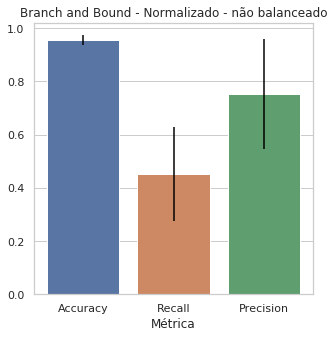

In [24]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_unbalanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_unbalanced =  pd.DataFrame(mean_unbalanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_unbalanced, ci = None)
plt.title('Branch and Bound - Normalizado - não balanceado')


plt.errorbar(x=[0],y=mean_unbalanced[0],yerr= (acc_max_unbalanced - mean_unbalanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_unbalanced[1],yerr= (rec_max_unbalanced - mean_unbalanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_unbalanced[2],yerr= (pre_max_unbalanced - mean_unbalanced[2]) , fmt='none', color = 'black')

fig_unbalanced.savefig('Branch_and_Bound-Normalizado-nao_balanceado-SVC', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

### Dataset Balanceado

[Text(157.00000000000003, 0.5, '')]

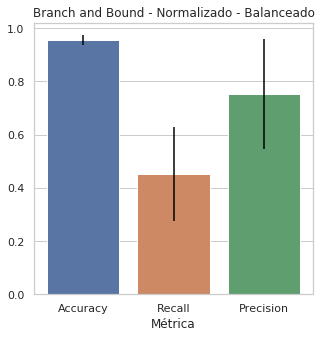

In [25]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_balanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_balanced =  pd.DataFrame(mean_balanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_balanced, ci = None)
plt.title('Branch and Bound - Normalizado - Balanceado')


plt.errorbar(x=[0],y=mean_balanced[0],yerr= (acc_max_balanced - mean_balanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_balanced[1],yerr= (rec_max_balanced - mean_balanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_balanced[2],yerr= (pre_max_balanced - mean_balanced[2]) , fmt='none', color = 'black')

fig_balanced.savefig('Branch_and_Bound-Normalizado-balanceado-SVC', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

## Armazena os Resultados para Gráfico Comparativo

In [27]:
path_to_save = '../../model_results/'

# Leitura dos resultados anteriores
all_models_results = pd.read_excel(path_to_save+'all_models_results.xlsx')

for metrica in df_mean_unbalanced.index:
    result = [
    '7',
    'SVC',
    'Branch and Bound - Normalizado - Desbalanceado',
    max_alpha_unbalanced,
    df_mean_unbalanced.loc[metrica]['Métrica'],
    df_mean_unbalanced.loc[metrica]['Value'],
    
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0: 'Atividade', 1: 'Algoritmo', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

# deleta da memoria
del result, aux_df

# Dataset Completo Balanceado
for metrica in df_mean_balanced.index:
    result = [
    '7',
    'SVC',
    'Branch and Bound - Normalizado - Balanceado',
    max_alpha_balanced,
    df_mean_balanced.loc[metrica]['Métrica'],
    df_mean_balanced.loc[metrica]['Value']
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0: 'Atividade', 1: 'Algoritmo', 2: 'Condicao', 
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

display(all_models_results)

# salva os resultados novos
try:
    all_models_results.to_excel(path_to_save+'all_models_results.xlsx', index=False)
    print('Resultados salvos com sucesso')
except Exception as e:
    print('Erro {}'.format(e))

Algoritmo Atividade                                           Condicao                              Melhores_Params    Metrica      Valor                                Intervalo_Confianca
0                       SVC         7      Dataset Completo Balanceado - Nao Normalizado                       ('rbf', 100, '0.0001')   Accuracy   0.962709                              [0.963, 0.948, 0.978]
1                       SVC         7      Dataset Completo Balanceado - Nao Normalizado                       ('rbf', 100, '0.0001')     Recall   0.876667                              [0.877, 0.793, 0.960]
2                       SVC         7      Dataset Completo Balanceado - Nao Normalizado                       ('rbf', 100, '0.0001')  Precision   0.690079                              [0.690, 0.564, 0.816]
3               Naive Bayes         6      Dataset Completo Balanceado - Nao Normalizado                                          0.8   Accuracy    0.93933                              [0.939, 0.917, 0.962]
4               Naive Bayes         6      Dataset Completo Balanceado - Nao Normalizado                                          0.8     Recall   0.876667                              [0.877, 0.793, 0.960]
5               Naive Bayes         6      Dataset Completo Balanceado - Nao Normalizado                                          0.8  Precision   0.547143                              [0.547, 0.433, 0.661]
6                       SVC         7          Dataset Completo Balanceado - Normalizado                       ('rbf', 100, '0.0001')   Accuracy   0.959193                              [0.959, 0.939, 0.979]
7                       SVC         7          Dataset Completo Balanceado - Normalizado                       ('rbf', 100, '0.0001')     Recall       0.91                              [0.910, 0.821, 0.999]
8                       SVC         7          Dataset Completo Balanceado - Normalizado                       ('rbf', 100, '0.0001')  Precision   0.673016                              [0.673, 0.529, 0.817]
9               Naive Bayes         6          Dataset Completo Balanceado - Normalizado                                          0.2   Accuracy   0.935841                              [0.936, 0.914, 0.957]
10              Naive Bayes         6          Dataset Completo Balanceado - Normalizado                                          0.2     Recall   0.876667                              [0.877, 0.793, 0.960]
11              Naive Bayes         6          Dataset Completo Balanceado - Normalizado                                          0.2  Precision   0.527698                              [0.528, 0.416, 0.639]
12                      SVC         7   Dataset Completo Desbalanceado - Nao Normalizado                       ('linear', 1, 'scale')   Accuracy   0.960383                              [0.960, 0.944, 0.977]
13                      SVC         7   Dataset Completo Desbalanceado - Nao Normalizado                       ('linear', 1, 'scale')     Recall       0.86                              [0.860, 0.764, 0.956]
14                      SVC         7   Dataset Completo Desbalanceado - Nao Normalizado                       ('linear', 1, 'scale')  Precision   0.677579                              [0.678, 0.545, 0.810]
15              Naive Bayes         6   Dataset Completo Desbalanceado - Nao Normalizado                                          0.6   Accuracy   0.955677                              [0.956, 0.936, 0.975]
16              Naive Bayes         6   Dataset Completo Desbalanceado - Nao Normalizado                                          0.6     Recall   0.716667                              [0.717, 0.578, 0.855]
17              Naive Bayes         6   Dataset Completo Desbalanceado - Nao Normalizado                                          0.6  Precision   0.675397                              [0.675, 0.499, 0.851]
18                      SVC         7       Dataset Completo Desbalanceado - Normaliz

Resultados salvos com sucesso
